# User Defined Rebound Collision Resolutions
In the [CloseEncounter](https://rebound.readthedocs.io/en/latest/ipython/CloseEncounters.html) example, we discuss methods for resolving collisions in REBOUND through exceptions and the use of the `sim.collision_resolve = "merge"` method.

Using the same 3-Body setup, let's explore how to define and implement bespoke collision resolutions in python and pass them to the `sim.collision_resolve` method.

In [1]:
import rebound
import numpy as np
import matplotlib.pyplot as plt

def setupSimulation():
    ''' Setup the 3-Body scenario'''
    sim = rebound.Simulation()
    sim.integrator = "ias15" # IAS15 is the default integrator, so we don't need this line
    sim.add(m=1.)
    sim.add(m=1e-3, a=1., r=np.sqrt(1e-3/3.)) # we now set collision radii!
    sim.add(m=5e-3, a=1.25, r=1.25*np.sqrt(5e-3/3.))
    sim.move_to_com()
    return sim

To reitterate the previous method, let's run the built-in `merge` collision resolution method

In [2]:
sim = setupSimulation()
sim.collision = "direct"
sim.collision_resolve = "merge" # Built in function

print("Particles in the simulation at t=%6.1f: %d"%(sim.t,sim.N))
print("System Mass: {}".format([p.m for p in sim.particles]))
sim.integrate(100.)
print("Particles in the simulation at t=%6.1f: %d"%(sim.t,sim.N))
print("System Mass: {}".format([p.m for p in sim.particles]))

Particles in the simulation at t=   0.0: 3
System Mass: [1.0, 0.001, 0.005]
Particles in the simulation at t= 100.0: 2
System Mass: [1.0, 0.006]


We can see above that two particles merged into one with a combined mass of 0.006.

Let's now try to impliment this collision function ourselves!

To do this, we need to write a function which we can pass to `sim.collision_resolve`. In this case let's define `my_merge`. 

Now, whenever a collision occours, REBOUND will pass our function two parameters:
 - sim_pointer: a pointer to the simulation object which the collision occured in. (You will need to use .contents atribute to retrieve the sim)
 - collided_particles_index: this parameter has two atributes, .p1 and .p2, which are respectively the index values of the two particles involved in the collision

Using these inputs, we can define the necessary logic to handle the collision however you wish and return 1 of the 3 values which tells REBOUND how to proceed..

Return Values:
 - 0: Simulation continues without changes
 - 1: remove p1 from simulation
 - 2: remove p2 from simulation

Let's look at how this information can be used to impliment the logic of the above `merge` method!

In [3]:
def my_merge(sim_pointer, collided_particles_index):

    sim = sim_pointer.contents # retreive the standard sim object
    ps = sim.particles # easy access to list of particles

    # sometimes p1 and p2 may be out of index order so we do this check

    swap = 0 # if swap == 0, p1 and p2 are in order
    i = collided_particles_index.p1 # lower index value
    j = collided_particles_index.p2 # higher index value
    if i > j: # if i is actually higher than j, swap them
        swap = 1 # if swap == 01, p1 and p2 are out of order
        i = collided_particles_index.p2 # lower index value
        j = collided_particles_index.p1 # higher index value


    # This part is exciting! We can execute additional code during collisions now!
    rebound.OrbitPlot(sim, xlim = (-1.3, 1.3), ylim = (-1.3, 1.3), color=['blue', 'green'])
    plt.title("Merging particle {} into {}".format(j, i), fontsize=14)
    plt.text(ps[1].x, ps[1].y, "1", fontsize = 20); plt.text(ps[2].x, ps[2].y, "2", fontsize = 20)
    # So we plot the scenario exactly at the timestep that the collision function is triggered

    # ------ Merging Logoic ------
    total_mass = ps[i].m + ps[j].m
    merged_planet = (ps[i] * ps[i].m + ps[j] * ps[j].m)/total_mass # conservation of momentum

    # merged radius (this method is for uniform spheres and may change for your scenario)
    r1 = ps[i].r # copy of p1's radius
    r2 = ps[j].r # copy of p2's radius
    merged_radius = (r1**3 + r2**3)**(1/3)
    # ----------------------------

    ps[i] = merged_planet # update p1's state vector (mass and radius will need corrections)
    ps[i].m = total_mass # update to total mass
    ps[i].r = merged_radius # update to joined radius

    return 1 if swap else 2 # return value coresponding with index of p2

Above we have defined a function that will merge two colliding particles in a totally inelastic collision. 

In the above definition the particle with the highest index value is discarded after collision. This is done to reduce the amount index changes in our particle list

Now let's pass our collision resolution to our sim...

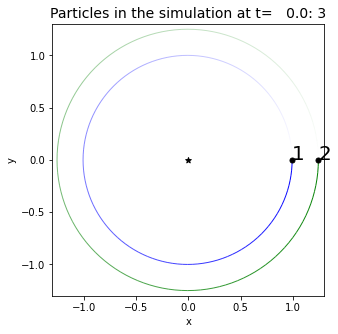

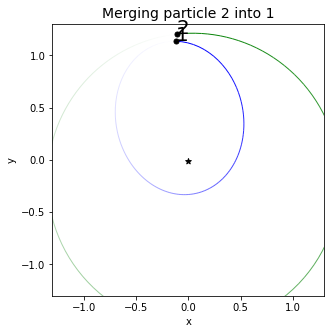

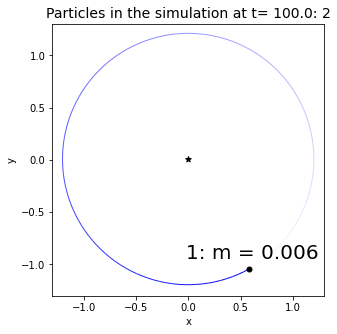

In [4]:
sim = setupSimulation()
sim.collision = "direct"
ps = sim.particles
sim.collision_resolve = my_merge # user defined collision resolution function

rebound.OrbitPlot(sim, xlim = (-1.3, 1.3), ylim = (-1.3, 1.3), color=['blue', 'green'])
plt.title("Particles in the simulation at t=%6.1f: %d"%(sim.t,sim.N), fontsize=14)
plt.text(ps[1].x, ps[1].y, "1", fontsize = 20); plt.text(ps[2].x, ps[2].y, "2", fontsize = 20)

sim.integrate(100.)

rebound.OrbitPlot(sim, xlim = (-1.3, 1.3), ylim = (-1.3, 1.3), color=['blue', 'green'])
plt.title("Particles in the simulation at t=%6.1f: %d"%(sim.t,sim.N), fontsize=14)
plt.text(ps[1].x-.6, ps[1].y+.1, "1: m = {}".format(ps[1].m), fontsize = 20)
plt.show()


We can see the result of this merger is as expected!

Not only that, but we were able to run additional code during the collision, in this case to make a plot, which can be very useful for logging, data collection, etc...

Now that you know the basics, you can extrapolate from to here scenarios where you may want collisions to behave differently such as adjusting our implimentations so that only  certain types of particles are removed during collisions while others remain.